# Hybrid PC on MNIST

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thebuckleylab/jpc/blob/main/examples/hybrid_pc.ipynb)

This notebook demonstrates how to train a hybrid predictive coding network ([Tschantz et al., 2023](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1011280)) that can both generate and classify MNIST digits.

In [1]:
# %%capture
# !pip install torch==2.3.1
# !pip install torchvision==0.18.1
# !pip install matplotlib==3.0.0

In [2]:
import jpc

import jax
import jax.numpy as jnp
import equinox as eqx
import equinox.nn as nn
import optax

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')  # ignore warnings

## Hyperparameters

We define some global parameters, including the network architecture, learning rate, batch size, etc.

In [3]:
SEED = 0

INPUT_DIM = 10
WIDTH = 300
DEPTH = 3
OUTPUT_DIM = 784
ACT_FN = "relu"

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_T1 = 50
TEST_EVERY = 100
N_TRAIN_ITERS = 300

## Dataset

Some utils to fetch MNIST.

In [4]:
def get_mnist_loaders(batch_size):
    train_data = MNIST(train=True, normalise=True)
    test_data = MNIST(train=False, normalise=True)
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True
    )
    return train_loader, test_loader


class MNIST(datasets.MNIST):
    def __init__(self, train, normalise=True, save_dir="data"):
        if normalise:
            transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(
                        mean=(0.1307), std=(0.3081)
                    )
                ]
            )
        else:
            transform = transforms.Compose([transforms.ToTensor()])
        super().__init__(save_dir, download=True, train=train, transform=transform)

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        img = torch.flatten(img)
        label = one_hot(label)
        return img, label


def one_hot(labels, n_classes=10):
    arr = torch.eye(n_classes)
    return arr[labels]


def plot_mnist_imgs(imgs, labels, n_imgs=10):
    plt.figure(figsize=(20, 2))
    for i in range(n_imgs):
        plt.subplot(1, n_imgs, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i].reshape(28, 28), cmap=plt.cm.binary_r)
        plt.xlabel(jnp.argmax(labels, axis=1)[i])
    plt.show()
    

## Train and test

Similar to a standard PC network, a hybrid model can be trained in a single line of code with [`jpc.make_hpc_step()`](https://thebuckleylab.github.io/jpc/api/Training/#jpc.make_hpc_step). Similarly, we can use [`jpc.test_hpc()`](https://thebuckleylab.github.io/jpc/api/Testing/#jpc.test_hpc) to compute different test metrics. Note that these functions are already "jitted" for optimised performance. Below we simply wrap each of these functions in training and test loops, respectively.

In [5]:
def evaluate(
      key,
      layer_sizes,
      batch_size,
      generator,
      amortiser,
      test_loader
):
    amort_accs, hpc_accs, gen_accs = 0, 0, 0
    for _, (img_batch, label_batch) in enumerate(test_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        amort_acc, hpc_acc, gen_acc, img_preds = jpc.test_hpc(
            key=key,
            layer_sizes=layer_sizes,
            batch_size=batch_size,
            generator=generator,
            amortiser=amortiser,
            input=label_batch,
            output=img_batch
        )
        amort_accs += amort_acc
        hpc_accs += hpc_acc
        gen_accs += gen_acc

    return (
        amort_accs / len(test_loader),
        hpc_accs / len(test_loader),
        gen_accs / len(test_loader),
        label_batch,
        img_preds
    )


def train(
      seed,
      input_dim,
      width,
      depth,
      output_dim,
      act_fn,
      batch_size,
      lr,
      max_t1,
      test_every,
      n_train_iters
):
    key = jax.random.PRNGKey(seed)
    key, *subkey = jax.random.split(key, 3)

    layer_sizes = [input_dim] + [width]*(depth-1) + [output_dim]
    generator = jpc.make_mlp(
        subkey[0], 
        input_dim=input_dim,
        width=width,
        depth=depth,
        output_dim=output_dim,
        act_fn=act_fn
    )
    # NOTE: input and output are inverted for the amortiser
    amortiser = jpc.make_mlp(
        subkey[1],
        input_dim=output_dim,
        width=width,
        depth=depth,
        output_dim=input_dim,
        act_fn=act_fn
    )
    
    gen_optim = optax.adam(lr)
    amort_optim = optax.adam(lr)
    optims = [gen_optim, amort_optim]
    
    gen_opt_state = gen_optim.init(
        (eqx.filter(generator, eqx.is_array), None)
    )
    amort_opt_state = amort_optim.init(eqx.filter(amortiser, eqx.is_array))
    opt_states = [gen_opt_state, amort_opt_state]

    train_loader, test_loader = get_mnist_loaders(batch_size)
    for iter, (img_batch, label_batch) in enumerate(train_loader):
        img_batch, label_batch = img_batch.numpy(), label_batch.numpy()

        result = jpc.make_hpc_step(
            generator=generator,
            amortiser=amortiser,
            optims=optims,
            opt_states=opt_states,
            input=label_batch,
            output=img_batch,
            max_t1=max_t1
        )
        generator, amortiser = result["generator"], result["amortiser"]
        gen_loss, amort_loss = result["losses"]
        if ((iter+1) % test_every) == 0:
            amort_acc, hpc_acc, gen_acc, label_batch, img_preds = evaluate(
                key,
                layer_sizes,
                batch_size,
                generator,
                amortiser,
                test_loader
            )
            print(
                f"Iter {iter+1}, gen loss={gen_loss:4f}, "
                f"amort loss={amort_loss:4f}, "
                f"avg amort test accuracy={amort_acc:4f}, "
                f"avg hpc test accuracy={hpc_acc:4f}, "
                f"avg gen test accuracy={gen_acc:4f}, "
            )
            if (iter+1) >= n_train_iters:
                break

    plot_mnist_imgs(img_preds, label_batch)
    return amortiser, generator


## Run

Iter 100, gen loss=0.657635, amort loss=0.060609, avg amort test accuracy=76.101761, avg hpc test accuracy=80.909454, avg gen test accuracy=80.498795, 
Iter 200, gen loss=0.573092, amort loss=0.044570, avg amort test accuracy=80.048080, avg hpc test accuracy=82.592148, avg gen test accuracy=82.391830, 
Iter 300, gen loss=0.576109, amort loss=0.043630, avg amort test accuracy=80.608971, avg hpc test accuracy=82.902641, avg gen test accuracy=83.012817, 


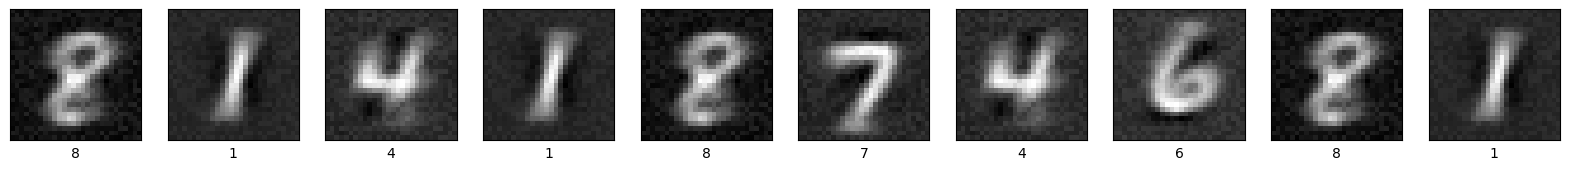

In [6]:
network = train(
    seed=SEED,
    input_dim=INPUT_DIM,
    width=WIDTH,
    depth=DEPTH,
    output_dim=OUTPUT_DIM,
    act_fn=ACT_FN,
    batch_size=BATCH_SIZE,
    lr=LEARNING_RATE,
    max_t1=MAX_T1,
    test_every=TEST_EVERY,
    n_train_iters=N_TRAIN_ITERS
)